Učitavnje Biblioteka

In [349]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation

from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

import keras_tuner as kt
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight

from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight



Unos podataka

In [350]:
# Podaci su smešteni u datoteci Occupancy.csv
# U prvih pet kolona se nalaze obeležja skupa podataka,
# dok šesta kolona predstavlja pripadnost klasi (0 ili 1)

data = pd.read_csv('Occupancy.csv')

# ulazne kolone (sve osim Occupancy)
ulaz = data.drop('Occupancy', axis=1)

# izlazna kolona
izlaz = data['Occupancy']

# izdvajanje po klasama
K0 = ulaz[izlaz == 0]
K1 = ulaz[izlaz == 1]

Raspodela uzoraka po klasama (tačka 1)

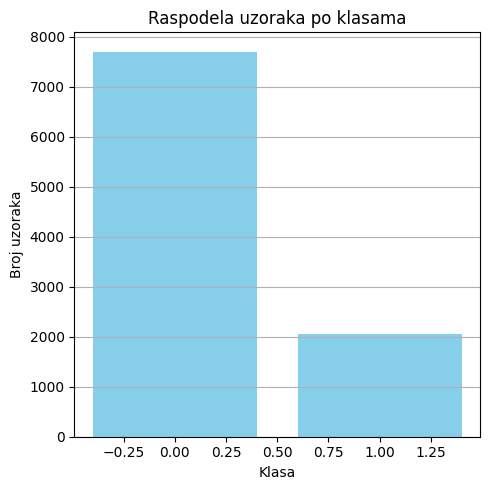

Broj podataka iz klase 0: 7703
Broj podataka iz klase 1: 2049


In [351]:
plt.figure(figsize=(5, 5))

class_counts = izlaz.value_counts().sort_index()

plt.bar([0,1], class_counts.values, color='skyblue')
plt.xlabel('Klasa')
plt.ylabel('Broj uzoraka')
plt.title('Raspodela uzoraka po klasama')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print('Broj podataka iz klase 0: ' + str(len(K0)))
print('Broj podataka iz klase 1: ' + str(len(K1)))

Podela na trening, validacioni i test skup

In [352]:
ulazTrening, ulazTest, izlazTrening, izlazTest = train_test_split(ulaz,
                                                                  izlaz,
                                                                  test_size=0.2,
                                                                  random_state=42)

ulazTrening, ulazVal, izlazTrening, izlazVal = train_test_split(ulazTrening, 
                                                                izlazTrening, 
                                                                train_size=0.8, 
                                                                random_state=42)

#Balansiranje trening skupa metodom oversampling-a

In [353]:
"""smt = SMOTE(random_state=45, k_neighbors=5)
ulazTreningOs, izlazTreningOs = smt.fit_resample(ulazTrening, izlazTrening)

K0os = ulazTreningOs.loc[izlazTreningOs==0, :]
K1os = ulazTreningOs.loc[izlazTreningOs==1, :]

print('Broj podataka trening skupa iz klase 0: ' + str(len(K0os)))
print('Broj podataka trening skupa iz klase 1: ' + str(len(K1os)))"""

"smt = SMOTE(random_state=45, k_neighbors=5)\nulazTreningOs, izlazTreningOs = smt.fit_resample(ulazTrening, izlazTrening)\n\nK0os = ulazTreningOs.loc[izlazTreningOs==0, :]\nK1os = ulazTreningOs.loc[izlazTreningOs==1, :]\n\nprint('Broj podataka trening skupa iz klase 0: ' + str(len(K0os)))\nprint('Broj podataka trening skupa iz klase 1: ' + str(len(K1os)))"

Balansiranje dodavanjem težina klasama

In [354]:
weights = class_weight.compute_class_weight(class_weight='balanced', 
                                            classes=np.unique(izlazTrening), 
                                            y=izlazTrening)
print('Težine klasa su: K0 - ' + str(weights[0]) + ', K1 - ' + str(weights[1]))

Težine klasa su: K0 - 0.6297941057731127, K1 - 2.426127527216174


Statistika obeležja

In [355]:
ulazTrening.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,6240.0,21.005994,1.028446,19.500000,20.290000,20.790000,21.55000,24.390000
Humidity,6240.0,29.853821,3.955225,21.890000,26.550000,30.166667,32.64500,39.500000
Light,6240.0,122.465254,209.239126,0.000000,0.000000,0.000000,192.81250,1581.000000
CO2,6240.0,754.550656,297.285178,484.666667,543.000000,641.625000,833.50000,1879.500000
HumidityRatio,6240.0,0.004584,0.000529,0.003279,0.004188,0.004584,0.00499,0.005769


Normalizacija podataka

In [356]:
scaler = MinMaxScaler().fit(ulazTrening)
ulazTreningNorm = scaler.transform(ulazTrening)
ulazTestNorm = scaler.transform(ulazTest)
ulazValNorm = scaler.transform(ulazVal)

pd.DataFrame(ulazTreningNorm, columns=ulazTrening.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,6240.0,0.307974,0.210316,0.0,0.161554,0.263804,0.419223,1.0
Humidity,6240.0,0.452233,0.224601,0.0,0.264622,0.469998,0.610733,1.0
Light,6240.0,0.077461,0.132346,0.0,0.000000,0.000000,0.121956,1.0
CO2,6240.0,0.193488,0.213133,0.0,0.041821,0.112528,0.250090,1.0
HumidityRatio,6240.0,0.524197,0.212575,0.0,0.365038,0.524324,0.687457,1.0


In [357]:
ulazTrening = ulazTreningNorm
ulazTest = ulazTestNorm
ulazVal = ulazValNorm

Traženje optimalnih hiperparametara modela

In [358]:
def make_model(hp):
    model = Sequential()
    model.add(Input((ulazTrening.shape[1],)))

    no_units = hp.Int('units', min_value=3, max_value=15, step=2)
    act = hp.Choice('activation', values=['sigmoid', 'relu', 'tanh'])
    model.add(Dense(units=no_units, kernel_initializer='he_normal'))   
    model.add(BatchNormalization())                                    
    model.add(Activation(act))                                          

    reg = hp.Float('reg', 0.001, 0.5, 0.005)
    model.add(Dense(5, kernel_regularizer=l2(reg), kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    drop = hp.Float('drop', 0, 0.8, 0.1)
    model.add(Dropout(drop))
    model.add(Dense(1, activation='sigmoid'))

    lr = hp.Float('learning_rate', 1e-5, 1e-2, 1e-4)
    opt = Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [359]:
stop_early = EarlyStopping(monitor='val_accuracy', 
                           patience=5, 
                           restore_best_weights=True, 
                           verbose=1)

tuner = kt.RandomSearch(make_model,
                        objective='val_accuracy',
                        overwrite=True,
                        max_trials=5)

tuner.search(ulazTrening, izlazTrening, 
             epochs=100, 
             batch_size=32,
             validation_data=(ulazVal, izlazVal),
             callbacks=[stop_early],
             verbose=3)

best_hyperparam = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 00m 11s]
val_accuracy: 0.9948750734329224

Best val_accuracy So Far: 0.9948750734329224
Total elapsed time: 00h 01m 06s


In [360]:
print('Optimalan broj neurona u prvom skrivenom sloju: ', best_hyperparam['units'])
print('Optimalna funkcija aktivacije u prvom skrivenom sloju: ', best_hyperparam['activation'])
print('Optimalan koeficijent regularizacije u drugom skrivenom sloju: ', best_hyperparam['reg'])
print('Optimalan dropout rate: ', best_hyperparam['drop'])
print('Optimalna konstanta obučavanja: ', best_hyperparam['learning_rate'])

Optimalan broj neurona u prvom skrivenom sloju:  5
Optimalna funkcija aktivacije u prvom skrivenom sloju:  relu
Optimalan koeficijent regularizacije u drugom skrivenom sloju:  0.186
Optimalan dropout rate:  0.7000000000000001
Optimalna konstanta obučavanja:  0.0013100000000000002


In [361]:
model = tuner.hypermodel.build(best_hyperparam)

stop_early = EarlyStopping(monitor='val_loss', 
                           patience=5, 
                           restore_best_weights=True)
history = model.fit(ulazTrening, izlazTrening, 
          epochs=100, 
          batch_size=32,
          callbacks=[stop_early],
          validation_data=(ulazVal, izlazVal),
          class_weight={0:weights[0], 1:weights[1]},
          verbose=0)


Grafik promena performansi tokom epoha treniranja (za trening i validacioni skup)

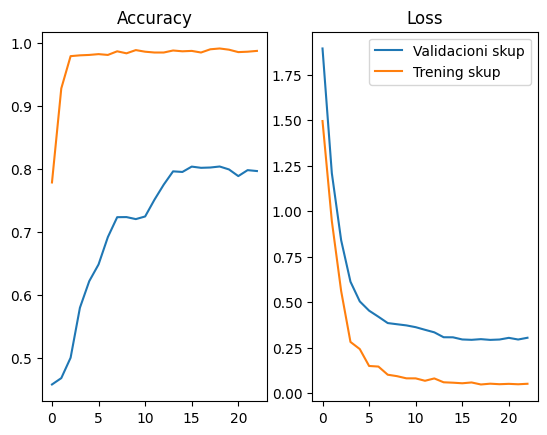

In [362]:
scaler = StandardScaler()
ulaz_trening_norm = scaler.fit_transform(ulazTrening)
ulaz_test_norm = scaler.transform(ulazTest)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.subplot(121)
plt.plot(acc, label='Validacioni skup')
plt.plot(val_acc, label='Trening skup')
plt.title('Accuracy')

plt.subplot(122)
plt.plot(loss, label='Validacioni skup')
plt.plot(val_loss, label='Trening skup')
plt.title('Loss')
plt.legend()
plt.show()

Evaluacija neuralne mreže

In [363]:
X = ulazTrening
# Ako izlazTrening nije numpy, pretvori
y = izlazTrening.to_numpy() if hasattr(izlazTrening, "to_numpy") else izlazTrening

kf = KFold(n_splits=3, shuffle=True, random_state=20)
accs = []

for fold_no, (train_idx, val_idx) in enumerate(kf.split(X, y), start=1):
    ut, it = X[train_idx], y[train_idx]
    uv, iv = X[val_idx], y[val_idx]

    model = tuner.hypermodel.build(best_hyperparam)
    stop_early = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

    history = model.fit(
                ut, it,
                epochs=100,
                batch_size=32,
                callbacks=[stop_early],
                class_weight={0:weights[0], 1:weights[1]},
                validation_data=(uv, iv),
                verbose=0
    )

    acc = model.evaluate(uv, iv, verbose=0)[1]
    accs.append(acc)
    print(f"Tačnost u {fold_no}. fold-u je: {100*acc:.2f}%")

print(f"Prosečna tačnost modela je: {100*np.mean(accs):.2f}%")


Tačnost u 1. fold-u je: 99.09%
Tačnost u 2. fold-u je: 98.94%
Tačnost u 3. fold-u je: 98.89%
Prosečna tačnost modela je: 98.97%


Matrica konfuzije na trening i test skupu

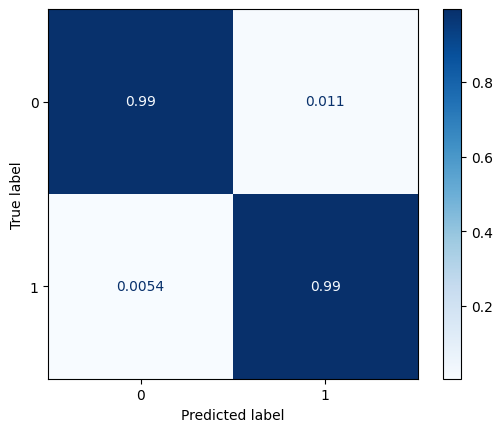

In [ ]:
cm = confusion_matrix(izlazTrening, np.round(model.predict(ulazTrening, verbose=0)), normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')
plt.show()

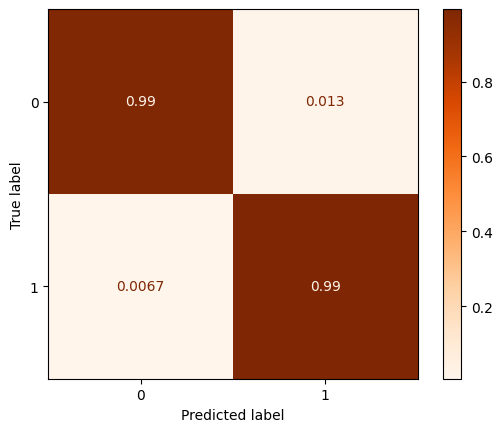

Tacnost na test skupu iznosi: 98.82111737570477%
Preciznost na test skupu iznosi: 98.85699984926455%
Osetljivost na test skupu iznosi: 98.82111737570477%
F1-skor: 98.82879305122%


In [365]:
izlazPred = model.predict(ulazTest, verbose=0)
izlazPred = np.round(izlazPred)

cm = confusion_matrix(izlazTest, izlazPred, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Oranges')
plt.show()

print('Tacnost na test skupu iznosi: ' + str(100*accuracy_score(izlazTest, izlazPred)) + '%')
print('Preciznost na test skupu iznosi: ' + str(100*precision_score(izlazTest, izlazPred, average='weighted')) + '%')
print('Osetljivost na test skupu iznosi: ' + str(100*recall_score(izlazTest, izlazPred, average='weighted')) + '%')
print('F1-skor: ' + str(100 * f1_score(izlazTest, izlazPred, average='weighted')) + '%')

Performanse

In [366]:
def print_metrics_from_cm(cm, class_labels):
    n_classes = len(class_labels)
    for i in range(n_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)

        accuracy = (TP + TN) / cm.sum() if cm.sum() > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        print(f"\nKlasa '{class_labels[i]}':")
        print(f"  Tačnost: {accuracy:.3f}")
        print(f"  Preciznost: {precision:.3f}")
        print(f"  Osetljivost: {recall:.3f}")
        print(f"  F1-skor: {f1:.3f}")

class_labels = ['0', '1']
print_metrics_from_cm(cm, class_labels)


Klasa '0':
  Tačnost: 0.990
  Preciznost: 0.993
  Osetljivost: 0.987
  F1-skor: 0.990

Klasa '1':
  Tačnost: 0.990
  Preciznost: 0.987
  Osetljivost: 0.993
  F1-skor: 0.990
